This is the import section

In [299]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import StandardScaler 
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from category_encoders import TargetEncoder
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
#from sklearn.compose import ColumnTransformer 
#from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import joblib


Fetch data frame

In [300]:
df_raw = pd.read_csv("./data/raw_database.csv", dtype={'Flight Phase':'str', 'Visibility':'str',
                                                       'Precipitation':'str','Species ID':'str',
                                                       'Species Name':'str', 'Species Quantity':'str',
                                                       'Flight Impact': 'str', 'Height':'Int64', 
                                                       'Speed':'float64','Distance':'float64',  
                                                       'Fatalities':'Int64', 'Injuries': 'Int64'}, low_memory=False) 
#'Engine1 Position':'float64','Engine2 Position':'float64',
#'Engine3 Position':'float64','Engine4 Position':'float64'
df_raw.shape

(174104, 66)

In [301]:
pd.set_option('display.max_columns', None)
df=df_raw.drop(['Record ID','Incident Year','Incident Month','Incident Day','Operator','Airport','Fatalities','Injuries'], axis=1)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns 
#df.head(20)

Remove rows where there is no animal invoved or where the species ID and the species name is not known.

In [302]:
no_of_null_id= df[df['Species ID'].isnull()]['Species ID'].count()
no_of_null_name = df[df['Species Name'].isnull()]
df=df.drop(no_of_null_name.index)
print(f"Number of null ID {no_of_null_id} and Name {no_of_null_name.shape[0]}")

Number of null ID 0 and Name 80


Checking if some entried had same ID but different animal name and such.

In [303]:
species_map = df.dropna(subset=["Species Name"]).set_index("Species ID")["Species Name"].to_dict()
df["New Species Name"] = df.apply(lambda row: species_map.get(row["Species ID"], row["Species Name"]), axis=1)
mismatched = df[df["Species Name"] != df["New Species Name"]] 
print(f"There are {mismatched.shape[0]} mismatched entries")
df=df.drop("New Species Name",axis=1)

There are 0 mismatched entries


Unknown animals are dropped. These aren't null rather the Animals with unknown name. Their ID starts with UNK.

In [304]:
df[df['Species ID'].str.startswith('UNK')].groupby(['Species Name']).count()
no_of_rows_unknown_name = df[df['Species ID'].str.startswith('UNK')]['Species ID'].count() 
print(f"Number of unknown animals {no_of_rows_unknown_name}.") 
df = df[~df['Species ID'].str.startswith('UNK')]

Number of unknown animals 80771.


What are the distinct values for each Categorical types?

In [305]:
distinct_values = {
    col: df[col].unique().tolist()
    for col in categorical_cols
    if col not in ['Species ID', 'Species Name']
}
table_df = pd.DataFrame([
    {'Features': col, 'Distinct Values': values}
    for col, values in distinct_values.items()
])
table_df


,Features,Distinct Values
0,Operator ID,"[DAL, HAL, UNK, MIL, USA, BUS, SWA, PVT, UPS, ..."
1,Aircraft,"[B-757-200, DC-9, UNKNOWN, F-16, B-737-200, HA..."
2,Aircraft Type,"[A, nan, B, J]"
3,Aircraft Make,"[148, 583, nan, 561, 443, 729, 395, 123, 70, 3..."
4,Aircraft Model,"[26, 90, nan, 13, 30, 24, 23, 14, 20, 3, 8, 2,..."
5,Engine Model,"[40, 10, nan, 1, 19, 37, 7, 4, 3, 34, 52, 31, ..."
6,Engine Type,"[D, nan, B, A, C, F, B/D, A/C, c, X]"
7,Engine1 Position,"[1, 5, nan, 7, 4, 6, 2, 3, C]"
8,Engine3 Position,"[nan, 1, 5, 4, CHANGE CODE, 3]"
9,Airport ID,"[KCVG, PHLI, KJAX, KMCO, KJWN, KFSM, KMSY, KIK..."


What are the top 10 species (The rest are categorized as others)?

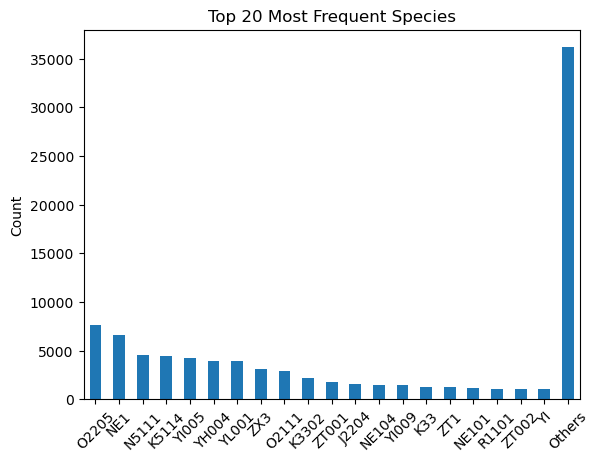

In [306]:
species_counts = df['Species ID'].value_counts()
top_species = species_counts.head(20)
other_species = pd.Series(species_counts.iloc[top_n:].sum(), index=['Others'])

# Combine the top species with the "Others" category
plot_data = pd.concat([top_species, other_species])
plot_data.plot(kind='bar')
plt.title(f'Top {top_n} Most Frequent Species')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()


CORRELATION

Checking the correlation of variables.

Since we will be doing 0.8 train test split and then if we use K more than 3 or more we would need 7 atleast hence we will be dropping any entries less than 10. And also After doing SMOTE We have seen that these class are creating noise because of the high imbalance. 

In [307]:
low_count_species = df['Species Name'].value_counts()
low_count_species = low_count_species[low_count_species < 10].index

df = df[~df['Species Name'].isin(low_count_species)]
dropped_species_count=low_count_species.unique().size
print(f"We have lost {dropped_species_count} species because they didnt have enough data for us to do SMOTE and add them to the model.")

We have lost 351 species because they didnt have enough data for us to do SMOTE and add them to the model.


In [308]:
cols_to_encode = [
    'Operator ID', 'Aircraft', 'Aircraft Type', 'State',
    'Aircraft Make', 'Aircraft Model', 'Engine Model', 'Engine Type',
    'Engine1 Position', 'Engine3 Position', 'Airport ID', 
    'FAA Region', 'Warning Issued', 'Flight Phase', 'Visibility',
    'Precipitation', 'Species Quantity','Species Name','Species ID',
    'Flight Impact'
]
X = df.copy()

# Fill missing values in numerical columns with the median
X[cols_to_encode] = X[cols_to_encode].fillna(X[cols_to_encode].mode()) 
X = X.dropna(subset=['Species Name'], axis=0)
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

encoder = TargetEncoder() 
X[cols_to_encode] = encoder.fit_transform(X[cols_to_encode],X['Species Name'])
corr_matrix = X.corr() 

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.7)]

print("Highly correlated features to consider dropping:", to_drop)


Highly correlated features to consider dropping: ['Engine Type', 'Engine1 Position', 'State', 'Species Name', 'Lights Damage']


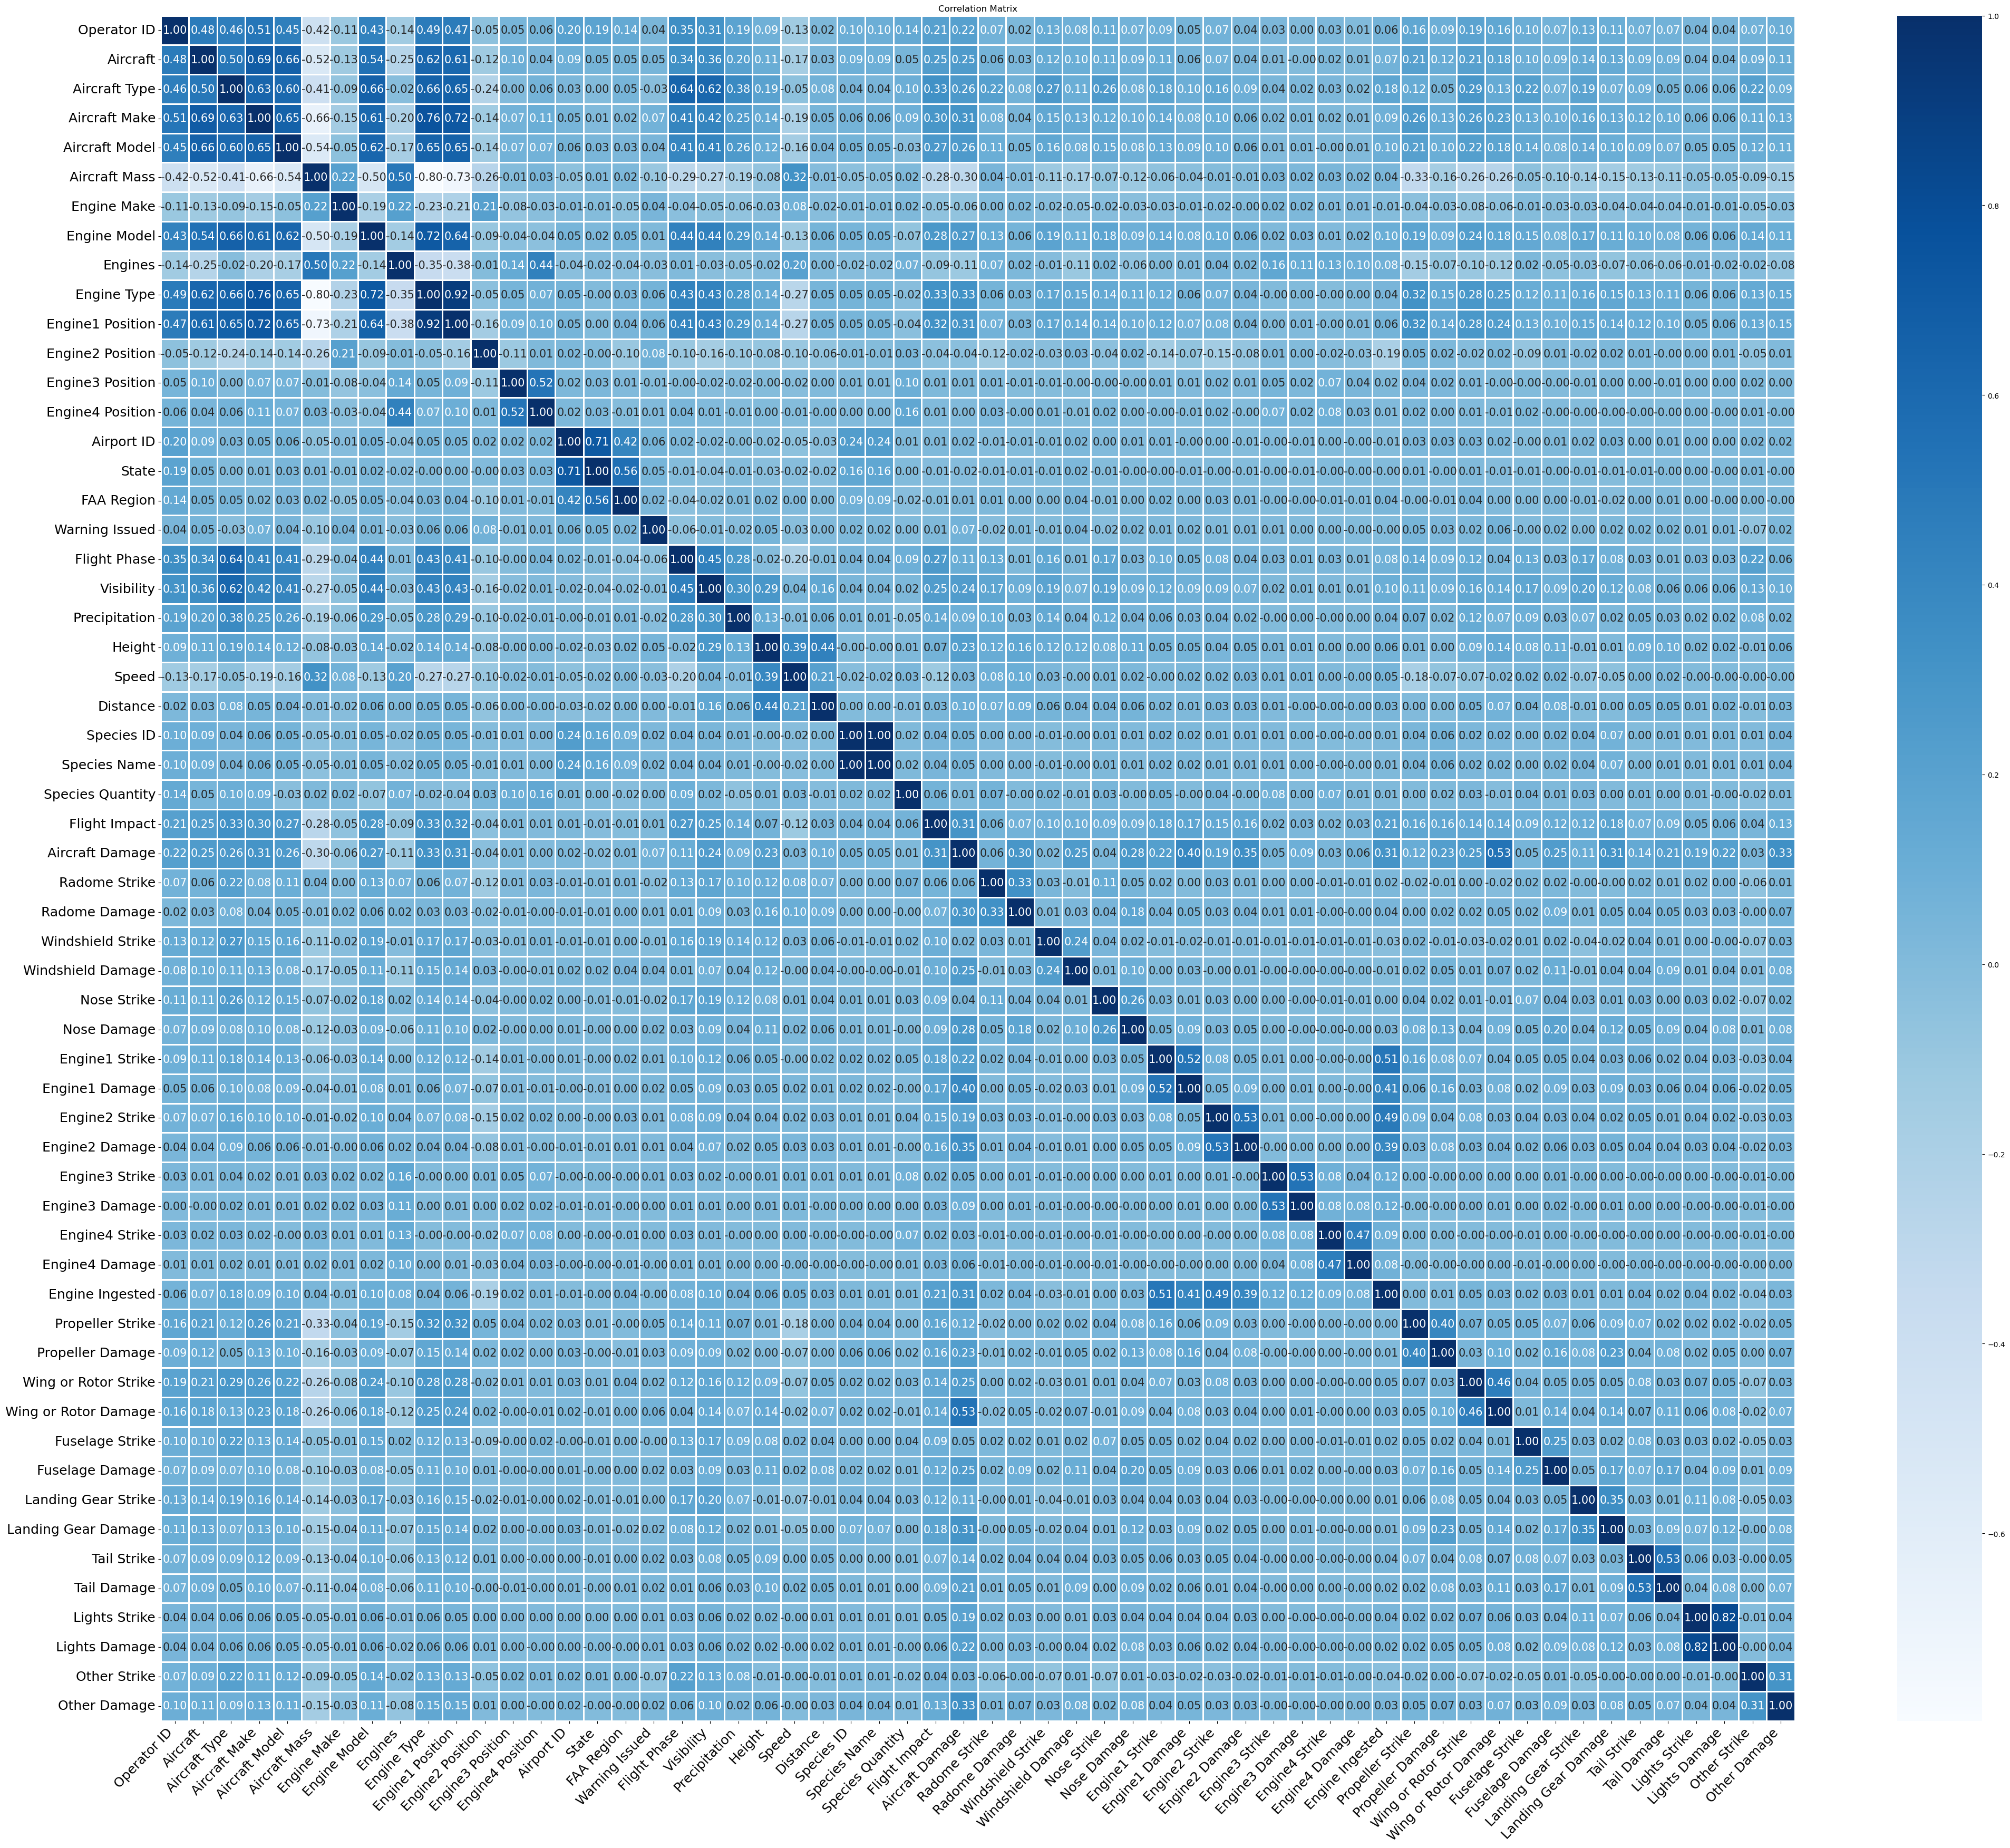

In [309]:
plt.figure(figsize=(50, 42))
sns.heatmap(corr_matrix, annot=True,fmt='.2f', linewidths=2,annot_kws={"size": 15},cmap='Blues') 
plt.title("Correlation Matrix")
plt.xticks(fontsize=18, rotation=46, ha='right')
plt.yticks(fontsize=18, rotation=0)
plt.show()

Spliting train and test

In [310]:
#I did 20 because there are species with 11 and then there are with 300
sampled_df = pd.concat([
    df_class.sample(n=min(len(df_class), 100), random_state=42)
    for _, df_class in df.groupby('Species Name')
])
X = sampled_df.drop(['Species Name', 'Species ID'], axis=1)
y = sampled_df['Species Name']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)


Imputation
Using Mode for categorical and Median for the numerical

In [311]:
def Impute(df,numerical_cols,categorical_cols,col_not_to_impute):
    df[numerical_cols] = df[numerical_cols].astype('float').fillna(df[numerical_cols].median())
    for col in categorical_cols:
        if(col in col_not_to_impute):
            continue
        df[col] = df[col].fillna(df[col].mode()[0]) 
    return df
X_train = Impute(X_train,numerical_cols,categorical_cols,['Species Name', 'Species ID'])
X_test = Impute(X_test,numerical_cols,categorical_cols,['Species Name', 'Species ID'])

Encode Features

In [312]:
col = categorical_cols.drop(['Species ID', 'Species Name']).tolist()
encoder = TargetEncoder() 
def Encoder(X_train,y_train, X_test, cols_to_encode, train=True):
    if train:
        return encoder.fit_transform(X_train[cols_to_encode], y_train)
    else:
        return encoder.transform(X_test[cols_to_encode])

X_train_enc = Encoder(X_train,y_train, X_test,col)
X_test = Encoder(X_train,y_train, X_test, col,train=False)
X_train = X_train_enc.copy()
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

Scaling the features.

In [313]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns) 

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns) 

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

SMOTE

In [314]:
old_size = X_train.shape
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train.astype(float), y_train)
print(f"Before SMOTE it was {old_size} and after SMOTE it is {X_train.shape}. \nSo we have {y_train.unique().size} species each with {y_train.value_counts().iloc[0]} entries in them.")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE it was (15627, 18) and after SMOTE it is (28720, 18). 
So we have 359 species each with 80 entries in them.


In [315]:
def print_accuracies(model , X_train,y_train, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model on training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred, zero_division=1)
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred)

    # Evaluate the model on test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred, zero_division=1)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

    # Output the results
    print(f"This acuracy scores are for {model_name}")
    print("Training Accuracy: ", train_accuracy)
    print("\nTraining Classification Report:\n", train_classification_report)
    print("\nTraining Confusion Matrix:\n", train_confusion_matrix)

    print("\nTest Accuracy: ", test_accuracy)
    print("\nTest Classification Report:\n", test_classification_report)
    print("\nTest Confusion Matrix:\n", test_confusion_matrix)

In [273]:
model = LogisticRegression(random_state=42)
print_accuracies(model , X_train,y_train, "LogisticRegression")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This acuracy scores are for LogisticRegression
Training Accuracy:  0.14032033426183843

Training Classification Report:
                                                     precision    recall  f1-score   support

                                  ALDER FLYCATCHER       0.05      0.16      0.08        80
                                AMERICAN ALLIGATOR       0.11      0.72      0.20        80
                                  AMERICAN BITTERN       0.11      0.17      0.13        80
                               AMERICAN BLACK DUCK       0.13      0.16      0.14        80
                                     AMERICAN COOT       0.15      0.03      0.04        80
                                     AMERICAN CROW       0.00      0.00      0.00        80
                            AMERICAN GOLDEN-PLOVER       0.00      0.00      0.00        80
                                AMERICAN GOLDFINCH       0.20      0.01      0.02        80
                                  AMERICAN KESTREL

In [274]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')
print_accuracies(model , X_train,y_train, "RandomForestClassifier")

This acuracy scores are for RandomForestClassifier
Training Accuracy:  0.750974930362117

Training Classification Report:
                                                     precision    recall  f1-score   support

                                  ALDER FLYCATCHER       0.93      0.94      0.93        80
                                AMERICAN ALLIGATOR       0.35      0.88      0.50        80
                                  AMERICAN BITTERN       1.00      0.95      0.97        80
                               AMERICAN BLACK DUCK       0.34      0.75      0.47        80
                                     AMERICAN COOT       0.88      0.38      0.53        80
                                     AMERICAN CROW       0.82      0.74      0.78        80
                            AMERICAN GOLDEN-PLOVER       0.73      0.50      0.59        80
                                AMERICAN GOLDFINCH       0.67      0.72      0.69        80
                                  AMERICAN KESTR

Do PCA to see changes

In [316]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
model = RandomForestClassifier(random_state=42, class_weight='balanced')
print_accuracies(model , X_train,y_train, "RandomForestClassifier")
joblib.dump(pca, 'pca.pkl')

This acuracy scores are for RandomForestClassifier
Training Accuracy:  0.750974930362117

Training Classification Report:
                                                     precision    recall  f1-score   support

                                  ALDER FLYCATCHER       0.93      0.94      0.93        80
                                AMERICAN ALLIGATOR       0.35      0.88      0.50        80
                                  AMERICAN BITTERN       1.00      0.95      0.97        80
                               AMERICAN BLACK DUCK       0.34      0.75      0.47        80
                                     AMERICAN COOT       0.94      0.36      0.52        80
                                     AMERICAN CROW       0.83      0.72      0.77        80
                            AMERICAN GOLDEN-PLOVER       0.73      0.50      0.59        80
                                AMERICAN GOLDFINCH       0.66      0.74      0.69        80
                                  AMERICAN KESTR

['pca.pkl']

In [276]:
joblib.dump(model, 'model.pkl')


['model.pkl']

In [277]:
""" pipeline = Pipeline([ 
    ('model', LogisticRegression(solver='saga', max_iter=2000,random_state=42))
])
param_grid = {'model__C': np.logspace(0.1, 3, 10)}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro',
                    n_jobs=-1, verbose=1, return_train_score=True)

grid.fit(X_train, y_train)

result=grid.cv_results_  
y_pred_test = grid.best_estimator_.predict(X_test)
final_test_score = f1_score(y_test, y_pred_test, average='macro')
def draw_error(max_depths,mean_train_scores,std_train_scores,mean_test_scores,std_test_scores,optimal_max_depth,final_test_score):
    plt.errorbar(max_depths, mean_train_scores, yerr=std_train_scores, label="Train F1 Score", fmt='-o')
    plt.errorbar(max_depths, mean_test_scores, yerr=std_test_scores, label="Test F1 Score", fmt='-o')

    plt.axvline(optimal_max_depth, color='green', linestyle='--', label=f'Optimal Max depth = {optimal_max_depth}')
    plt.axhline(final_test_score, color='red', linestyle=':', label=f'Final Test F1 = {final_test_score:.2f}')

    plt.xlabel("Max Depth")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Max Depth with Error Bars")
    plt.legend(loc="lower left", title="Shape description") 
    plt.show()


draw_error(result['param_model__max_depth'],result['mean_train_score'],
           result['std_train_score'],result['mean_test_score'],
           result['std_test_score'],grid.best_params_['model__max_depth'],final_test_score )
 """

' pipeline = Pipeline([ \n    (\'model\', LogisticRegression(solver=\'saga\', max_iter=2000,random_state=42))\n])\nparam_grid = {\'model__C\': np.logspace(0.1, 3, 10)}\ngrid = GridSearchCV(pipeline, param_grid, cv=3, scoring=\'f1_macro\',\n                    n_jobs=-1, verbose=1, return_train_score=True)\n\ngrid.fit(X_train, y_train)\n\nresult=grid.cv_results_  \ny_pred_test = grid.best_estimator_.predict(X_test)\nfinal_test_score = f1_score(y_test, y_pred_test, average=\'macro\')\ndef draw_error(max_depths,mean_train_scores,std_train_scores,mean_test_scores,std_test_scores,optimal_max_depth,final_test_score):\n    plt.errorbar(max_depths, mean_train_scores, yerr=std_train_scores, label="Train F1 Score", fmt=\'-o\')\n    plt.errorbar(max_depths, mean_test_scores, yerr=std_test_scores, label="Test F1 Score", fmt=\'-o\')\n\n    plt.axvline(optimal_max_depth, color=\'green\', linestyle=\'--\', label=f\'Optimal Max depth = {optimal_max_depth}\')\n    plt.axhline(final_test_score, color=\'